In [79]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import seaborn as sns
import xlsxwriter
import scipy.stats as stats
import os,sys
import pickle
import random
import math
import time
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from collections import OrderedDict
import pandas as pd
import shapefile as shp
import geopandas as gpd
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from get_population_by_state import GetAgeSex


In [80]:
county_shape_file = "data/basemap/cb_2018_us_county_5m"
state_shape_file = "data/basemap/cb_2018_us_state_5m"
data_file = "data/lur_no2/lur_no2_merged_with_pop_v6.csv"
AF_file = "odds_ratio_module/data/{}/PR_IR_AF.csv"

In [81]:
df = pd.read_csv(data_file)
df = df[df['year'] == 2019]
# df.groupby(['state_code']).agg({'population': 'sum', 'state_name': 'first'})

In [172]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


def draw_us_map(pop_lookup, df, col, title='2019', adjust=True, 
                cmap_title='2019', annot='a)'):
    # Set the lower left and upper right limits of the bounding box:
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='h',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')
    shp_info = m.readshapefile(state_shape_file, 'states',
                               drawbounds=True, color='lightgrey')
    
    EXCLUDE = ['United States Virgin Islands','Puerto Rico', 
               "Guam", 'Commonwealth of the Northern Mariana Islands', 'American Samoa']
    colors={}
    statenames=[]
    cmap = plt.cm.tab20c # use 'hot' colormap
    if "trend" in cmap_title.lower():
        cmap = plt.get_cmap("coolwarm")
    else:
        cmap = plt.get_cmap("Reds")  
    l = df[col].tolist()
    if adjust:
        vmin, vmax =np.percentile(l, 20), np.percentile(l, 80)
    else:
        vmin, vmax = min(l), max(l)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in EXCLUDE:
            pop = pop_lookup[statename]
            colors[statename] = mapper.to_rgba(pop)
        statenames.append(statename)
        
    ax = plt.gca() # get current axes instance
    ax.text(0.01, 1, annot, transform=ax.transAxes, size=16, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    

    for nshape,seg in enumerate(m.states):
        if statenames[nshape] == 'Alaska':
        # Alaska is too big. Scale it down to 35% first, then transate it. 
            seg = [(0.35*i[0]+ 1600000, 0.35*i[1]-1830000) for i in seg]
        if statenames[nshape] == 'Hawaii':
            seg = [(i[0]+ 5750000, i[1]-1500000) for i in seg]
        if statenames[nshape] not in EXCLUDE:
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            ax.add_patch(poly)
    plt.title(title)
    fig = plt.gcf()

    cax = fig.add_axes([0.24,0.08, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel(cmap_title)
    if "trend" in cmap_title:
        cb.ax.set_xticks([vmin/2, vmax/2], ["$\it{decreasing}$",  "$\it{increasing}$"])
  
    plt.savefig("output_images/{}.png".format(cmap_title.replace(" ", "_")), bbox_inches='tight', dpi=600)
    plt.show()
    return m, shp_info

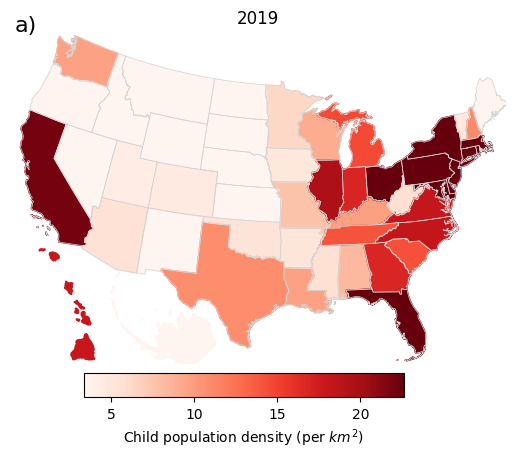

In [173]:
def plot_basemap(year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True):    
    df = GetAgeSex(year, pop_type='CHILD').read_file_by_population()
    pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
    m, b = draw_us_map(pop_lookup, df, col, annot='a)', cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

cmap_title = 'Child population density (per $km^2$)'
title = '2019'
df = plot_basemap('2019', 'DENSITY', state_name='NAME', annot='a)', 
                  cmap_title=cmap_title, title=title, adjust=True)

In [18]:
def calcorr(x):
    y = range(0, len(x))
#     return (x[-1]-x[0])/x[0]
    return np.corrcoef(x,y)[0][1]

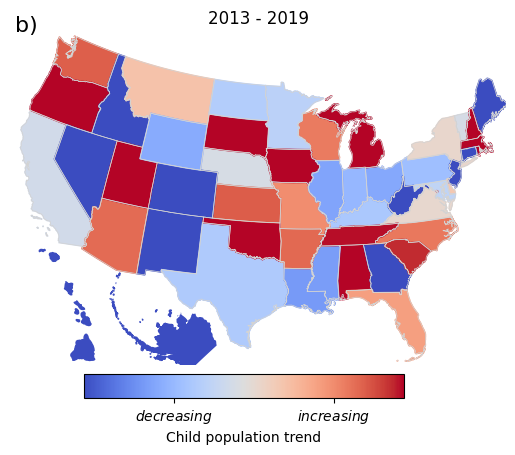

,fips,state_code,year,population,state_name,pred_wght
3,1001,1,2013,13741,Alabama,NaN
4,1001,1,2014,13614,Alabama,NaN
5,1001,1,2015,13405,Alabama,NaN
6,1001,1,2016,13333,Alabama,NaN
7,1001,1,2017,13231,Alabama,NaN
...,...,...,...,...,...,...
31415,56045,56,2015,1556,Wyoming,12.715851
31416,56045,56,2016,1559,Wyoming,10.340000
31417,56045,56,2017,1434,Wyoming,NaN
31418,56045,56,2018,1442,Wyoming,NaN


In [174]:
def plot_basemap_for_trend(col, state_name = 'NAME', annot='b)', 
                  cmap_title=cmap_title, title=title, adjust=False):    
    df = pd.read_csv(data_file)
    df = df[df['year']>=2013]
    mdf = df.groupby(['state_code']).agg({'population': list, 'state_name': 'first'}).reset_index()
    mdf[col] = mdf['population'].apply(calcorr)
    
    pop_lookup = {row[state_name]: row[col] for index, row in mdf.iterrows()}
    pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']
    m, b = draw_us_map(pop_lookup, mdf, col, adjust=adjust, 
                       cmap_title=cmap_title, title=title,annot=annot)
    return df

cmap_title= 'Child population trend'
title="2013 - 2019"
plot_basemap_for_trend('corr', state_name='state_name', annot='b)', 
                  cmap_title=cmap_title, title=title, adjust=True)

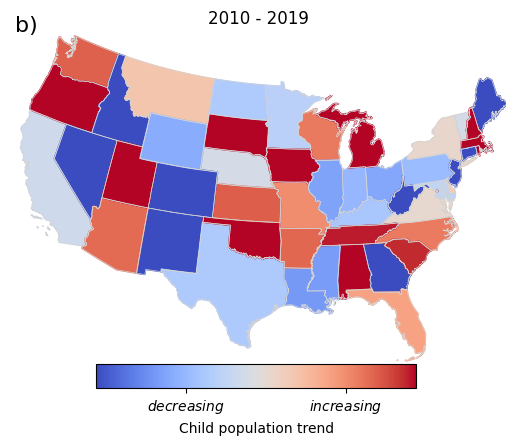

,fips,state_code,year,population,state_name,pred_wght
0,1001,1,2010,14541,Alabama,NaN
1,1001,1,2011,14383,Alabama,NaN
2,1001,1,2012,14168,Alabama,NaN
3,1001,1,2013,13741,Alabama,NaN
4,1001,1,2014,13614,Alabama,NaN
...,...,...,...,...,...,...
31415,56045,56,2015,1556,Wyoming,12.715851
31416,56045,56,2016,1559,Wyoming,10.340000
31417,56045,56,2017,1434,Wyoming,NaN
31418,56045,56,2018,1442,Wyoming,NaN


In [19]:
cmap_title= 'Child population trend'
title="2013 - 2019"
plot_basemap_for_trend('corr', state_name='state_name', annot='b)', 
                  cmap_title=cmap_title, title=title, adjust=True)

In [10]:
if __name__ == "__main__":
    df = pd.DataFrame()
    for year in range(2010, 2020):
        tdf, data = get_county_and_colors(year, 'fips', 'pred_wght')
        df = df.append(tdf)
        l = df['incidences_trap'].tolist()
        q1, q2, q3, q01, q85 = np.percentile(l, 25), np.percentile(l, 50), np.percentile(l, 75), np.percentile(l, 10), np.percentile(l, 85)
        df["col_2_norm"] = df['incidences_trap'].apply(normalize, args=(q1, q2, q3, q01, q85))
        df["col_2_norm"] = (df["col_2_norm"] - df["col_2_norm"].min())/ (df["col_2_norm"].max() - df["col_2_norm"].min())
  

    cmap = plt.get_cmap('Reds')
    for year in range(2010, 2020):
        m = draw_us_map()
        tdf = df[df['year'] == year]
        ax = plt.gca() 
        for index, county in enumerate(m.counties_info):
            fips = "{}{}".format(county.get('STATEFP'), county.get('COUNTYFP'))
            tdf['fips'] = tdf['fips'].astype(str)
            try:
                color = tdf.loc[tdf["fips"] == fips, "col_2_norm"].item()
            except:
                color = np.nan
            shapenum = county.get('SHAPENUM')
            countyseg = m.counties[shapenum-1]
            if not pd.isna(color):
                poly = Polygon(countyseg, facecolor=cmap(color))  # edgecolor="white"
                ax.add_patch(poly)    

        plt.title('Asthma incidences due to TRAP for {}'.format(year))
        # Get rid of some of the extraneous whitespace matplotlib loves to use.
        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.savefig("output_images/basemap_trap/{}.png".format(year), bbox_inches='tight')
        plt.show()
        
        
        
        
        
        
        
        

NameError: name 'get_county_and_colors' is not defined

In [ ]:
df

In [ ]:
plt.boxplot([i for i in df['col_2_norm'].tolist() if not pd.isna(i)])

In [ ]:
df = pd.read_csv('data/ambient_no2/daily_42602_2018.csv')

In [ ]:
def get_county_fips(x):
    x = str(x)
    if len(x) == 1:
        return "00{}".format(x)
    elif len(x) == 2:
        return "0{}".format(x)
    else:
        return x

df['county_fips'] = df['County Code'].apply(get_county_fips)
df['STATE'] = df['State Code'].astype(str)
df['fips'] = df['STATE'] + df['county_fips']

In [ ]:
len(df['fips'].unique())

In [58]:
##
df1 = pd.read_csv("output_files/PR_IR_AF_2010_2019_no2.csv")
df2 = pd.read_csv("C:/Users/harsh/OneDrive - University of Toronto/Projects/Environmental Discrimination/odds_ratio_module/data/2010/PR_IR_AF.csv")
df3 = pd.read_csv("C:/Users/harsh/OneDrive - University of Toronto/Projects/Environmental Discrimination/odds_ratio_module/data/2010/PR_IR_AF_no2.csv")
df4 = pd.read_csv("C:/Users/harsh/OneDrive - University of Toronto/Projects/Environmental Discrimination/output_files/for_R_no2.csv")

In [56]:
df1 = df1[df1['year'] == 2010]

In [70]:
columns = ['state_code', 'PR', 'IR', 'SAF']
df1[columns].head(5)

,state_code,PR,IR,SAF
3,1.0,0.092412,0.008370,0.124638
4,1.0,0.131293,0.009747,0.115057
5,1.0,0.084102,0.008171,0.114835
6,1.0,0.080348,0.008951,0.050278
7,1.0,0.077128,0.008004,0.044234


In [71]:
df2[columns].head(5)

,state_code,PR,IR,SAF
0,1.0,0.114040,0.010105,0.100075
1,2.0,0.089486,0.010105,0.000000
2,4.0,0.093765,0.010105,0.385936
3,5.0,0.089486,0.010105,0.133490
4,6.0,0.089486,0.010105,0.409527


In [72]:
df3[columns].head(5)

,state_code,PR,IR,SAF
0,1.0,0.114040,0.010105,0.100075
1,2.0,0.089486,0.010105,0.000000
2,4.0,0.093765,0.010105,0.385936
3,5.0,0.089486,0.010105,0.133490
4,6.0,0.089486,0.010105,0.409527


In [73]:
df1.shape

(357, 13)

In [74]:
df1 = df1[df1['year']>=2013]

In [75]:
df4.shape

(357, 29)

In [76]:
setA = {(row['state_code'], row['year']) for index, row in df1.iterrows()}
setB = {(row['state_code'], row['year']) for index, row in df4.iterrows()}

In [77]:
df1[df1['year'] == 2013][columns].head(10)

,state_code,PR,IR,SAF
3,1.0,0.092412,0.008370,0.124638
13,2.0,0.092412,0.008370,0.000000
23,4.0,0.108087,0.008370,0.392951
33,5.0,0.092412,0.008370,0.127764
43,6.0,0.088534,0.005150,0.411209
53,8.0,0.092412,0.008370,0.250128
63,9.0,0.097897,0.003786,0.316561
73,10.0,0.092412,0.008370,0.239436
83,11.0,0.135064,0.008370,0.390972
93,12.0,0.092412,0.008370,0.141990


In [78]:
df4[df4['year'] == 2013][columns].head(10)

,state_code,PR,IR,SAF
0,1,0.091582,0.008022,0.124638
1,2,0.091582,0.008022,0.000000
2,4,0.108087,0.008022,0.392951
3,5,0.091582,0.008022,0.127764
4,6,0.088534,0.005150,0.411209
5,8,0.091582,0.008022,0.250128
6,9,0.097897,0.003786,0.316561
7,10,0.091582,0.008022,0.239436
8,11,0.135064,0.008022,0.390972
9,12,0.091582,0.008022,0.141990
